# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import glob
import os
import random
import pathlib

import pandas as pd
import torch
from Bio.PDB.Polypeptide import index_to_one
from collections import OrderedDict
from torch.utils.data import DataLoader, Dataset

from cavity_model import (
    CavityModel,
    ResidueEnvironment,
    ResidueEnvironmentsDataset,
)
import helpers

from visualization import scatter_pred_vs_true, plot_validation_performance

%load_ext nb_black

<IPython.core.display.Javascript object>

# Cavity Model

Download and process Cavity Model data

In [2]:
# # Hack to find the conda activate path since bash scripts
# # don't necessarily work with the conda activate command
# conda_path = !which conda
# conda_path = list(conda_path)[0]
# conda_activate_path = pathlib.Path(conda_path).parent.parent / "bin" / "activate"
# if not conda_activate_path.is_file():
#     raise FileNotFoundError(
#         "Could not find your conda activate path needed for running bash scripts."
#     )

<IPython.core.display.Javascript object>

In [3]:
# # Run shell script that takes a .txt file with PDBIDs as input.
# !./get_and_parse_pdbs_for_cavity_model.sh $conda_activate_path data/pdbids_2336.txt

<IPython.core.display.Javascript object>

Global variables

In [4]:
# Main parameters
WARM_START = "cavity_models/model_epoch_01.pt"
DEVICE = "cuda"  # "cpu" or "cuda"
TRAIN_VAL_SPLIT = 0.8
BATCH_SIZE = 100
SHUFFLE_PDBS = True
LEARNING_RATE = 3e-4
EPOCHS = 2
PATIENCE_CUTOFF = 0
EPS = 1e-9

# Parameters specific to downstream model
BATCH_SIZE_DDG = 40
SHUFFLE_DDG = True
LEARNING_RATE_DDG = 1e-3
EPOCHS_DDG = 200

<IPython.core.display.Javascript object>

Load Parsed PDBs and perform train/val split

In [5]:
if WARM_START is None:
    parsed_pdb_filenames = sorted(glob.glob("data/pdbs/parsed/*coord*"))
    if SHUFFLE_PDBS:
        random.shuffle(parsed_pdb_filenames)
    (
        dataloader_train,
        dataset_train,
        dataloader_val,
        dataset_val,
    ) = helpers._train_val_split(
        parsed_pdb_filenames, TRAIN_VAL_SPLIT, DEVICE, BATCH_SIZE
    )
else:
    print(f"Warm start: {WARM_START}")

Warm start: cavity_models/model_epoch_01.pt


<IPython.core.display.Javascript object>

Train the cavity model

In [6]:
if WARM_START is None:
    # Define model
    cavity_model_net = CavityModel(DEVICE).to(DEVICE)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cavity_model_net.parameters(), lr=LEARNING_RATE)

    # Create directory for model files
    models_dirpath = "cavity_models/"
    if not os.path.exists(models_dirpath):
        os.mkdir(models_dirpath)

    # Train loop
    best_model_path = helpers._train_loop(
        dataloader_train,
        dataloader_val,
        cavity_model_net,
        loss_function,
        optimizer,
        EPOCHS,
        PATIENCE_CUTOFF,
    )
else:
    print(f"Warm start: {WARM_START}")

Warm start: cavity_models/model_epoch_01.pt


<IPython.core.display.Javascript object>

# ddG Prediction

Parse PDBs for DMS, Guerois and Protein G data sets

In [7]:
# # Parse PDBs for which we have ddG data
# !./get_and_parse_pdbs_for_dowstream_task.sh $conda_activate_path

<IPython.core.display.Javascript object>

Make dict for residue environments for easy look up

In [8]:
# Create temporary residue environment datasets as dicts to more easily match ddG data
parsed_pdbs_wildcards = {
    "dms": "data/data_dms/pdbs_parsed/*coord*",
    "protein_g": "data/data_protein_g/pdbs_parsed/*coord*",
    "guerois": "data/data_guerois/pdbs_parsed/*coord*",
    "symmetric": "data/data_symmetric/pdbs_parsed/*coord*",
}

resenv_datasets_look_up = {}
for dataset_key, pdbs_wildcard in parsed_pdbs_wildcards.items():
    parsed_pdb_filenames = sorted(glob.glob(pdbs_wildcard))
    dataset = ResidueEnvironmentsDataset(parsed_pdb_filenames, transformer=None)
    dataset_look_up = {}
    for resenv in dataset:
        key = (
            f"{resenv.pdb_id}{resenv.chain_id}_{resenv.pdb_residue_number}"
            f"{index_to_one(resenv.restype_index)}"
        )
        dataset_look_up[key] = resenv
    resenv_datasets_look_up[dataset_key] = dataset_look_up

<IPython.core.display.Javascript object>

Load ddG data to dataframe

In [9]:
ddg_data_dict = OrderedDict()
ddg_data_dict = {
    "dms": pd.read_csv("data/data_dms/ddgs_parsed.csv"),
    "protein_g": pd.read_csv("data/data_protein_g/ddgs_parsed.csv"),
    "guerois": pd.read_csv("data/data_guerois/ddgs_parsed.csv"),
    "symmetric_direct": pd.read_csv("data/data_symmetric/ddgs_parsed_direct.csv"),
    "symmetric_inverse": pd.read_csv("data/data_symmetric/ddgs_parsed_inverse.csv"),
}

<IPython.core.display.Javascript object>

Populate dataframes with wt ResidueEnvironment objects and wt and mt restype indices

In [10]:
helpers._populate_dfs_with_resenvs(ddg_data_dict, resenv_datasets_look_up)

Dropping data points where residue is not defined in structure or due to missing parsed pdb file
dropped 1187 / 8096 data points from dataset dms
dropped    0 /  907 data points from dataset protein_g
dropped    0 /  911 data points from dataset guerois
dropped    0 /  342 data points from dataset symmetric_direct
dropped    0 /  342 data points from dataset symmetric_inverse


<IPython.core.display.Javascript object>

Populate dataframes with predicted NLLs and isolated WT and MT predicted NLLs as well as NLFs

In [11]:
# Load best performing cavity model from previos training
if WARM_START:
    best_model_path = WARM_START

cavity_model_infer_net = CavityModel(DEVICE).to(DEVICE)
cavity_model_infer_net.load_state_dict(torch.load(best_model_path))
cavity_model_infer_net.eval()

helpers._populate_dfs_with_nlls_and_nlfs(
    ddg_data_dict, cavity_model_infer_net, DEVICE, BATCH_SIZE, EPS
)

<IPython.core.display.Javascript object>

## Results without downstream model

### Plot with PDB statistics

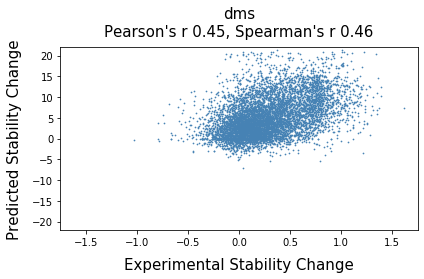

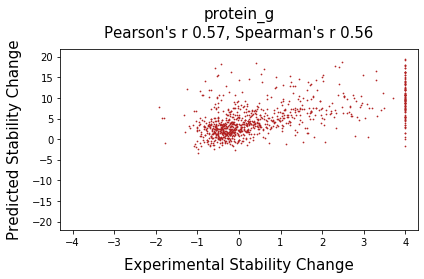

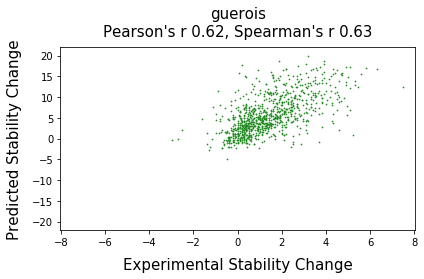

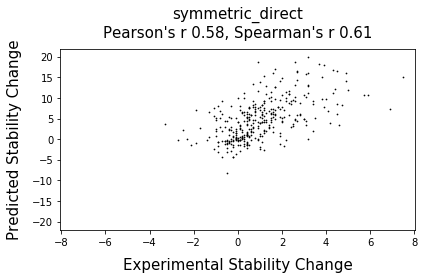

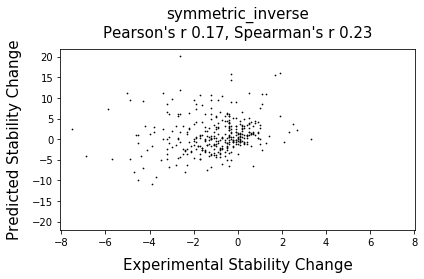

<IPython.core.display.Javascript object>

In [12]:
colors = ["steelblue", "firebrick", "forestgreen", "black", "black"]
for color, data_key in zip(colors, ddg_data_dict.keys()):
    fig, ax = scatter_pred_vs_true(
        ddg_data_dict[data_key]["ddg"],
        ddg_data_dict[data_key]["ddg_pred_no_ds"],
        color=color,
        title=data_key,
    )

### Plot with IDP statistics

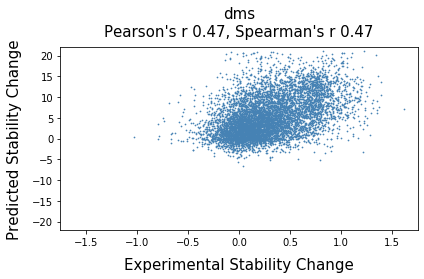

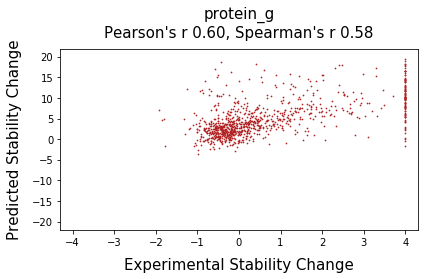

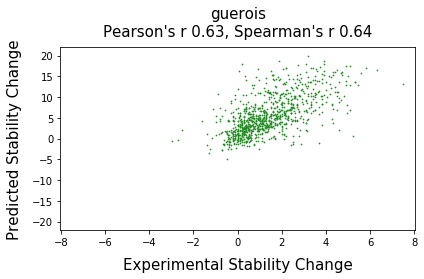

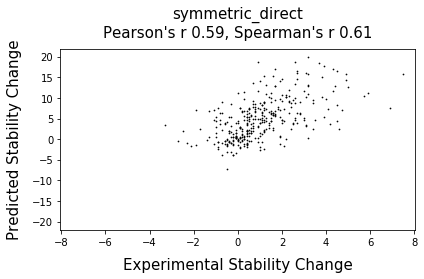

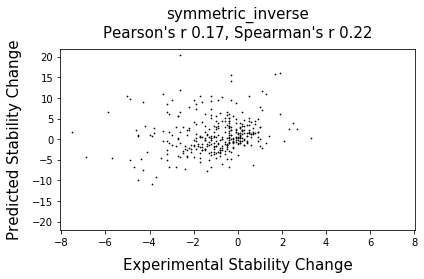

<IPython.core.display.Javascript object>

In [13]:
for color, data_key in zip(colors, ddg_data_dict.keys()):
    fig, ax = scatter_pred_vs_true(
        ddg_data_dict[data_key]["ddg"],
        ddg_data_dict[data_key]["ddg_pred_idp_no_ds"],
        color=color,
        title=data_key,
    )

Merge direct and inverse dfs

In [14]:
# Rename columns so they specify if it is the direct or inverse direction
symmetric_direct_df = ddg_data_dict["symmetric_direct"]
symmetric_direct_df.columns = [
    name + "_dir" if "_dir" not in name else name
    for name in symmetric_direct_df.columns
]
symmetric_inverse_df = ddg_data_dict["symmetric_inverse"]
symmetric_inverse_df.columns = [
    name + "_inv" if "_inv" not in name else name
    for name in symmetric_inverse_df.columns
]

# Inner merge both dataframes
ddg_data_dict["symmetric_both"] = pd.merge(
    symmetric_direct_df,
    symmetric_inverse_df,
    how="inner",
    left_on="merge_column_dir",
    right_on="merge_column_inv",
)

<IPython.core.display.Javascript object>

Make prediction based on both structures

In [15]:
symmetric_both_df = ddg_data_dict["symmetric_both"]
symmetric_both_df["ddg_pred_no_ds_both_dir"] = symmetric_both_df.apply(
    lambda row: 0.5 * (row["ddg_pred_no_ds_dir"] - row["ddg_pred_no_ds_inv"]), axis=1
)
symmetric_both_df["ddg_pred_no_ds_both_inv"] = symmetric_both_df.apply(
    lambda row: 0.5 * (row["ddg_pred_no_ds_inv"] - row["ddg_pred_no_ds_dir"]), axis=1
)

<IPython.core.display.Javascript object>

In [16]:
symmetric_both_df = ddg_data_dict["symmetric_both"]
symmetric_both_df["ddg_pred_idp_no_ds_both_dir"] = symmetric_both_df.apply(
    lambda row: 0.5 * (row["ddg_pred_idp_no_ds_dir"] - row["ddg_pred_idp_no_ds_inv"]),
    axis=1,
)
symmetric_both_df["ddg_pred_idp_no_ds_both_inv"] = symmetric_both_df.apply(
    lambda row: 0.5 * (row["ddg_pred_idp_no_ds_inv"] - row["ddg_pred_idp_no_ds_dir"]),
    axis=1,
)

<IPython.core.display.Javascript object>

### Plot prediction using both structures

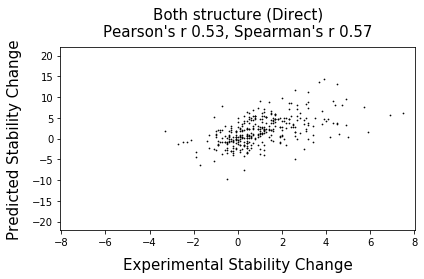

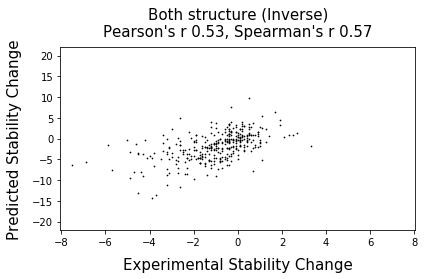

<IPython.core.display.Javascript object>

In [17]:
# Plot prediction for ddg direct using both structures
fig, ax = scatter_pred_vs_true(
    ddg_data_dict["symmetric_both"]["ddg_dir"],
    ddg_data_dict["symmetric_both"]["ddg_pred_no_ds_both_dir"],
    color="black",
    title="Both structure (Direct)",
)

# Plot prediction for ddg inverse using both structures
fig, ax = scatter_pred_vs_true(
    ddg_data_dict["symmetric_both"]["ddg_inv"],
    ddg_data_dict["symmetric_both"]["ddg_pred_no_ds_both_inv"],
    color="black",
    title="Both structure (Inverse)",
)

### Plot prediction using both structures (IDP statistics)

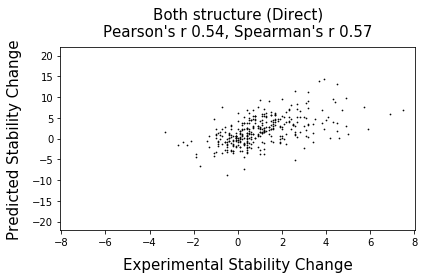

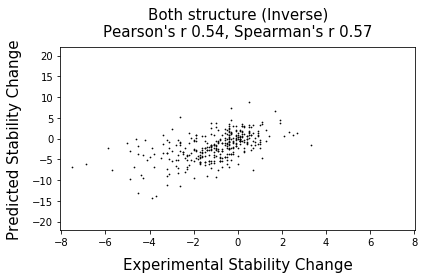

<IPython.core.display.Javascript object>

In [18]:
# Plot prediction for ddg direct using both structures
fig, ax = scatter_pred_vs_true(
    ddg_data_dict["symmetric_both"]["ddg_dir"],
    ddg_data_dict["symmetric_both"]["ddg_pred_idp_no_ds_both_dir"],
    color="black",
    title="Both structure (Direct)",
)

# Plot prediction for ddg inverse using both structures
fig, ax = scatter_pred_vs_true(
    ddg_data_dict["symmetric_both"]["ddg_inv"],
    ddg_data_dict["symmetric_both"]["ddg_pred_idp_no_ds_both_inv"],
    color="black",
    title="Both structure (Inverse)",
)

### Phaistos statistics

In [19]:
from helpers import _add_flanking_seq_fragments

# Add flanking sequence fragments for protein g
raw_pdbs = glob.glob("data/data_protein_g/pdbs_raw/*.pdb")
for raw_pdb in raw_pdbs:
    helpers._add_flanking_seq_fragments(
        ddg_data_dict,
        "protein_g",
        raw_pdb,
    )

# Add flanking sequence fragments for guerois
raw_pdbs = glob.glob("data/data_guerois/pdbs_raw/*.pdb")
for raw_pdb in raw_pdbs:
    helpers._add_flanking_seq_fragments(
        ddg_data_dict,
        "guerois",
        raw_pdb,
    )

# Add flanking sequence fragments for dms
raw_pdbs = glob.glob("data/data_dms/pdbs_raw/*.pdb")
for raw_pdb in raw_pdbs:
    helpers._add_flanking_seq_fragments(
        ddg_data_dict,
        "dms",
        raw_pdb,
    )

/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4562.
  PDBConstructionWarning)
/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4563.
  PDBConstructionWarning)
/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4564.
  PDBConstructionWarning)
/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4565.
  PDBConstructionWarning)
/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain A is discontin

/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4264.
  PDBConstructionWarning)
/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4334.
  PDBConstructionWarning)
/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4385.
  PDBConstructionWarning)
/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4551.
  PDBConstructionWarning)


<IPython.core.display.Javascript object>

In [20]:
# Output CSVs (So Wouter can simulate them)
ddg_data_dict["protein_g"][
    ["pdbid", "variant", "left_flank", "right_flank", "wt_restype", "mt_restype"]
].to_csv("data/data_protein_g/sequence_flanks_protein_g.csv")
ddg_data_dict["dms"][
    ["pdbid", "variant", "left_flank", "right_flank", "wt_restype", "mt_restype"]
].to_csv("data/data_dms/sequence_flanks_dms.csv")
ddg_data_dict["guerois"][
    ["pdbid", "variant", "left_flank", "right_flank", "wt_restype", "mt_restype"]
].to_csv("data/data_guerois/sequence_flanks_guerois.csv")

<IPython.core.display.Javascript object>

#### Protein G (phaistos statistics)

In [21]:
# # DROP SOME ROWS FOR QUICKER TESTING
# ddg_data_dict["protein_g"] = ddg_data_dict["protein_g"].iloc[0:10]

<IPython.core.display.Javascript object>

In [22]:
data_set = "protein_g"
data_set_title = "Protein G"

helpers._infer_probabilities_for_center_residues(
    ddg_data_dict, data_set, cavity_model_infer_net, DEVICE, EPS, is_wt=True
)
helpers._infer_probabilities_for_center_residues(
    ddg_data_dict, data_set, cavity_model_infer_net, DEVICE, EPS, is_wt=False
)
helpers._add_ddg_preds_with_unfolded_state(ddg_data_dict, data_set)

fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_wt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, wt unfolded",
)
fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_mt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, mt unfolded",
)

fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_wt_and_mt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, mt and wt unfolded",
)

0 1PGA
1 1PGA
2 1PGA
3 1PGA
4 1PGA
5 1PGA
6 1PGA
7 1PGA
8 1PGA
9 1PGA
10 1PGA
11 1PGA
12 1PGA


KeyboardInterrupt: 

<IPython.core.display.Javascript object>

#### Guerois (Phaistos statistics)

In [ ]:
# # DROP SOME ROWS FOR QUICKER TESTING
# ddg_data_dict["guerois"] = ddg_data_dict["guerois"].iloc[0:10]

In [ ]:
data_set = "guerois"
data_set_title = "Guerois"

helpers._infer_probabilities_for_center_residues(
    ddg_data_dict, data_set, cavity_model_infer_net, DEVICE, EPS, is_wt=True
)
helpers._infer_probabilities_for_center_residues(
    ddg_data_dict, data_set, cavity_model_infer_net, DEVICE, EPS, is_wt=False
)
helpers._add_ddg_preds_with_unfolded_state(ddg_data_dict, data_set)

fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_wt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, wt unfolded",
)
fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_mt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, mt unfolded",
)

fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_wt_and_mt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, mt and wt unfolded",
)

#### DMS (Phaistos statistics)

In [ ]:
# # DROP SOME ROWS FOR QUICKER TESTING
# ddg_data_dict["dms"] = ddg_data_dict["dms"].iloc[0:10]

In [ ]:
data_set = "dms"
data_set_title = "DMS"

helpers._infer_probabilities_for_center_residues(
    ddg_data_dict, data_set, cavity_model_infer_net, DEVICE, EPS, is_wt=True
)
helpers._infer_probabilities_for_center_residues(
    ddg_data_dict, data_set, cavity_model_infer_net, DEVICE, EPS, is_wt=False
)
helpers._add_ddg_preds_with_unfolded_state(ddg_data_dict, data_set)

fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_wt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, wt unfolded",
)
fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_mt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, mt unfolded",
)

fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_wt_and_mt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, mt and wt unfolded",
)

##### Molecular dynamics

In [24]:
ddg_dataset = "protein_g"
helpers._infer_molecular_dynamics_nlls(
    ddg_data_dict, ddg_dataset, DEVICE, EPS, cavity_model_infer_net
)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [ ]:
stride = 40

md_nlls_wt_given_wt = []
md_nlls_mt_given_wt = []


md_datasets = {}
for i, row in ddg_data_dict["protein_g"].iterrows():
    print(i)
    md_pdbs = glob.glob(
        f"data/data_protein_g/molecular_dynamics/pdbs_parsed/{row['pdbid']}_*npz"
    )[::stride]

    # Store whole parsed pdbs for quicker parsing
    if row["pdbid"] in md_datasets:
        md_pdbs_dataset = md_datasets[row["pdbid"]]
    else:
        md_pdbs_dataset = ResidueEnvironmentsDataset(sorted(md_pdbs), transformer=None)
        md_datasets[row["pdbid"]] = md_pdbs_dataset

    wt_restype = row["variant"][0]
    pdb_residue_number = int(row["variant"][1:-1])

    # Extract resenvs that match restype and residue number
    extracted_resenvs_md = []
    for resenv in md_pdbs_dataset:
        if (
            wt_restype == index_to_one(resenv.restype_index)
            and pdb_residue_number == resenv.pdb_residue_number
        ):
            extracted_resenvs_md.append(resenv)

    if len(extracted_resenvs_md) == 0:
        print(f"Did not find matchin resenvs for {row['variant']}")

    dataset_variant_md = ResidueEnvironmentsDataset(
        extracted_resenvs_md, transformer=ToTensor(DEVICE)
    )
    dataloader_variant_md = DataLoader(
        dataset_variant_md,
        batch_size=len(dataset_variant_md),
        shuffle=False,
        drop_last=False,
        collate_fn=ToTensor(DEVICE).collate_cat,
    )
    # Get X tensor
    x_batch, _ = next(iter(dataloader_variant_md))

    # Predict
    y_pred = (
        -torch.log(softmax(cavity_model_infer_net(x_batch), dim=-1) + EPS)
        .detach()
        .cpu()
        .numpy()
    )

    md_nlls_wt_given_wt.append(y_pred[:, row["wt_idx"]])
    md_nlls_mt_given_wt.append(y_pred[:, row["mt_idx"]])
ddg_data_dict[ddg_dataset]["wt_nll_md"] = md_nlls_wt_given_wt
ddg_data_dict[ddg_dataset]["mt_nll_md"] = md_nlls_mt_given_wt

In [ ]:
# # MD + pdb statistics
# ddg_data_dict[ddg_dataset]["ddg_pred_md_pdb_statistics_no_ds"] = ddg_data_dict[
#     "protein_g"
# ].apply(
#     lambda row: row["mt_nll_md"].mean()
#     - row["mt_nlf"]
#     - row["wt_nll_md"].mean()
#     + row["wt_nlf"],
#     axis=1,
# )

# # MD + idp statistics
# ddg_data_dict[ddg_dataset]["ddg_pred_md_idp_statistics_no_ds"] = ddg_data_dict[
#     "protein_g"
# ].apply(
#     lambda row: row["mt_nll_md"].mean()
#     - row["mt_idp_nlf"]
#     - row["wt_nll_md"].mean()
#     + row["wt_idp_nlf"],
#     axis=1,
# )

# # MD + phaistos WT statistics
# ddg_data_dict[ddg_dataset]["ddg_pred_md_phaistos_wt_statistics_no_ds"] = ddg_data_dict[
#     "protein_g"
# ].apply(
#     lambda row: row["mt_nll_md"].mean()
#     - row["fragment_nll_mt_given_wt"].mean()
#     - row["wt_nll_md"].mean()
#     + row["fragment_nll_wt_given_wt"].mean(),
#     axis=1,
# )

# # MD + phaistos MT statistics
# ddg_data_dict[ddg_dataset]["ddg_pred_md_phaistos_mt_statistics_no_ds"] = ddg_data_dict[
#     "protein_g"
# ].apply(
#     lambda row: row["mt_nll_md"].mean()
#     - row["fragment_nll_mt_given_mt"].mean()
#     - row["wt_nll_md"].mean()
#     + row["fragment_nll_wt_given_mt"].mean(),
#     axis=1,
# )

# ddg_data_dict[ddg_dataset]["ddg_pred_md_phaistos_mt_and_wt_statistics_no_ds"] = ddg_data_dict[
#     "protein_g"
# ].apply(
#     lambda row: row["mt_nll_md"].mean()
#     - (row["fragment_nll_mt_given_wt"].mean() + row["fragment_nll_mt_given_mt"].mean())
#     / 2
#     - row["wt_nll_md"].mean()
#     + (
#         row["fragment_nll_wt_given_wt"].mean()
#         + row["fragment_nll_wt_given_mt"].mean() / 2
#     ),
#     axis=1,
# )


In [ ]:
# fig, ax = scatter_pred_vs_true(
#     ddg_data_dict["protein_g"]["ddg"],
#     ddg_data_dict["protein_g"]["ddg_pred_md_pdb_statistics_no_ds"],
#     color="black",
#     title="protein G, MD1",
# )
# fig, ax = scatter_pred_vs_true(
#     ddg_data_dict["protein_g"]["ddg"],
#     ddg_data_dict["protein_g"]["ddg_pred_md_idp_statistics_no_ds"],
#     color="black",
#     title="protein G, MD2",
# )

# fig, ax = scatter_pred_vs_true(
#     ddg_data_dict["protein_g"]["ddg"],
#     ddg_data_dict["protein_g"]["ddg_pred_md_phaistos_wt_statistics_no_ds"],
#     color="black",
#     title="protein G, MD3",
# )

# fig, ax = scatter_pred_vs_true(
#     ddg_data_dict["protein_g"]["ddg"],
#     ddg_data_dict["protein_g"]["ddg_pred_md_phaistos_mt_statistics_no_ds"],
#     color="black",
#     title="protein G, MD4",
# )

# fig, ax = scatter_pred_vs_true(
#     ddg_data_dict["protein_g"]["ddg"],
#     ddg_data_dict["protein_g"]["ddg_pred_md_phaistos_mt_and_wt_statistics_no_ds"],
#     color="black",
#     title="protein G, MD5",
# )

# Downstream model

### Performance without augmentation

Define training dataloader and eval dataloaders

In [ ]:
# ddg_dataloaders_train_dict = helpers._get_ddg_training_dataloaders(
#     ddg_data_dict, BATCH_SIZE_DDG, SHUFFLE_DDG
# )
# ddg_dataloaders_val_dict = helpers._get_ddg_validation_dataloaders(ddg_data_dict)

Train and report on the data that is not used during training

In [ ]:
# pearsons_r_results_dict = helpers._train_downstream_and_evaluate(
#     ddg_dataloaders_train_dict,
#     ddg_dataloaders_val_dict,
#     DEVICE,
#     LEARNING_RATE_DDG,
#     EPOCHS_DDG,
# )

In [ ]:
# for key in pearsons_r_results_dict.keys():
#     _ = plot_validation_performance(key, pearsons_r_results_dict[key])

### Performance with augmentation

Before training we "augment" our dataset simply by adding the reverse mutation with -ddG value

In [ ]:
# ddg_data_dict_augmented = helpers._augment_with_reverse_mutation(ddg_data_dict)

Define training dataloader (augmented data) and eval dataloaders (original data)

In [ ]:
# ddg_dataloaders_train_dict = helpers._get_ddg_training_dataloaders(
#     ddg_data_dict_augmented, BATCH_SIZE_DDG, SHUFFLE_DDG
# )
# ddg_dataloaders_val_dict = helpers._get_ddg_validation_dataloaders(ddg_data_dict)

Train and report on the data that is not used during training

In [ ]:
# pearsons_r_results_dict = helpers._train_downstream_and_evaluate(
#     ddg_dataloaders_train_dict,
#     ddg_dataloaders_val_dict,
#     DEVICE,
#     LEARNING_RATE_DDG,
#     EPOCHS_DDG,
# )

In [ ]:
# for key in pearsons_r_results_dict.keys():
#     _ = plot_validation_performance(key, pearsons_r_results_dict[key])